In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ks_2samp
from scipy.spatial.distance import jensenshannon
import numpy as np
import math
import pickle

from tvae_only_project.tvae import TVAE


In [2]:
df = pd.read_csv("processed_data.csv")
print(df.columns)

Index(['Comments', 'Lane number', 'Date', 'business', 'senior', 'family',
       'young', 'PRM', 'regular', 'Experience', 'Time Start Baggage drop off',
       'Number of boxes', 'Time End Baggage drop off', 'Time Start WTMD',
       'Time Start WTMD 2', 'Time Start WTMD 3', 'Time Start WTMD check',
       'Time End WTMD check', 'Time Start ETD check', 'Time End ETD check',
       'Time Start Baggage reclaim', 'Time End Baggage reclaim', 'Group size',
       'Time Start Baggage Check', 'Time End Baggage Check', 'sheet_name',
       'delta_time'],
      dtype='object')


In [3]:
print(df.isnull().sum())

Comments                       1309
Lane number                       0
Date                              0
business                       1961
senior                         1875
family                         2166
young                          2033
PRM                            2380
regular                        1338
Experience                        2
Time Start Baggage drop off       1
Number of boxes                   2
Time End Baggage drop off         1
Time Start WTMD                   5
Time Start WTMD 2              2072
Time Start WTMD 3              2402
Time Start WTMD check          2191
Time End WTMD check            2192
Time Start ETD check           2092
Time End ETD check             2096
Time Start Baggage reclaim        9
Time End Baggage reclaim          9
Group size                        3
Time Start Baggage Check       2231
Time End Baggage Check         2236
sheet_name                        0
delta_time                        9
dtype: int64


In [4]:
# Create a new variable ETD in df: 1 if "Time Start ETD check" is not NaN, 0 otherwise
df["ETD"] = df["Time Start ETD check"].notna().astype(int)

In [5]:
# Create a new DataFrame with columns that do not include "Time", except for "delta_time"
data = df[[col for col in df.columns if "Time" not in col or col == "delta_time"]]
# print(data.head())

In [6]:
data = data.drop(columns=['Comments', 'Date', 'sheet_name'])
# print(data.head())

In [7]:
for col in data.columns:
    if data[col].isnull().sum() > 1000:
        data[col].fillna(0, inplace=True)

# print(data.isnull().sum())

/var/folders/46/30710m094qv2_dhfs08nzzd00000gn/T/ipykernel_95504/1906828378.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[col].fillna(0, inplace=True)


In [8]:
discrete_columns = [col for col in data.columns if col != 'delta_time']


In [9]:

data.dropna(inplace=True)

In [ ]:
model=TVAE(epochs=10000, verbose=True, cuda=True)
model.fit(data, discrete_columns=discrete_columns)

Loss: 13.024:   0%|          | 9/10000 [00:00<04:20, 38.32it/s]

Epoch [1/10000] Average Loss: 25.2705


Loss: 3.689:  10%|█         | 1009/10000 [00:24<03:13, 46.45it/s]

Epoch [1000/10000] Average Loss: 3.9953


Loss: 2.853:  20%|██        | 2009/10000 [00:46<02:52, 46.40it/s]

Epoch [2000/10000] Average Loss: 2.7375


Loss: 2.822:  28%|██▊       | 2802/10000 [01:05<02:38, 45.38it/s]

In [ ]:
num_samples = len(data)# Number of new synthetic samples desired
synthetic_data = model.sample(num_samples)

# View generated data
print("Synthetic data generated:")
print(synthetic_data.head())

Synthetic data generated:
   Lane number  business  senior  family  young  PRM  regular  Experience  \
0            3       0.0     0.0     0.0    1.0  0.0      0.0         1.0   
1            3       0.0     0.0     0.0    0.0  0.0      0.0         1.0   
2            3       0.0     0.0     0.0    1.0  0.0      1.0         1.0   
3            3       1.0     0.0     0.0    0.0  0.0      0.0         1.0   
4            3       0.0     1.0     0.0    0.0  0.0      0.0         1.0   

   Number of boxes  Group size  delta_time  ETD  
0              2.0         2.0  323.083230    0  
1              1.0         1.0  239.694004    0  
2              3.0         2.0  420.237567    0  
3              2.0         1.0  232.271570    0  
4              1.0         1.0  284.933369    0  


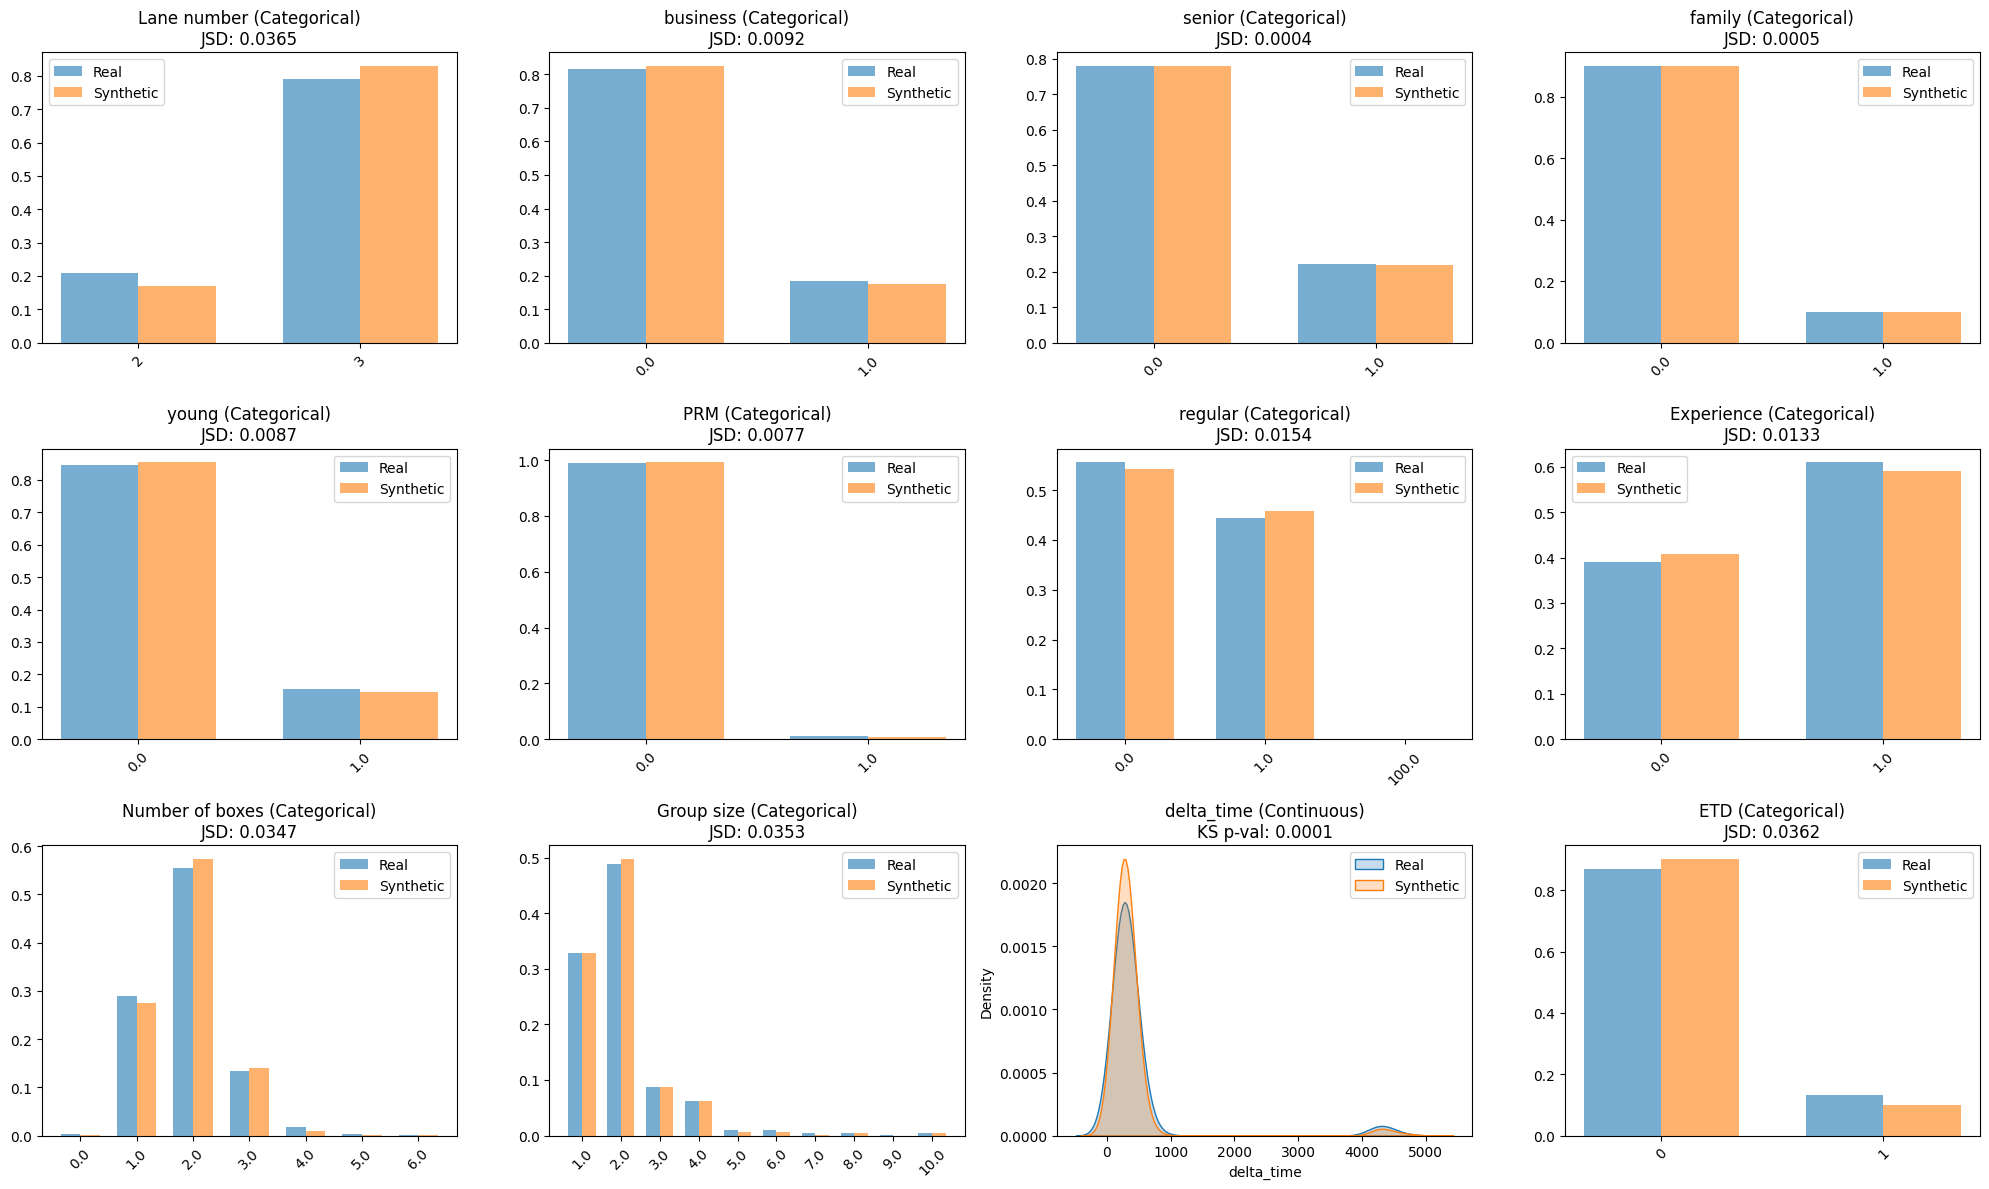

In [ ]:
def compare_distributions(real_df, synthetic_df, categorical_columns=None, continuous_columns=None, n_rows=3):
    """
    Compare distributions of real and synthetic data, arranged in `n_rows` of subplots.

    Args:
        real_df (pd.DataFrame): Real dataset.
        synthetic_df (pd.DataFrame): Synthetic dataset.
        categorical_columns (list of str, optional): List of categorical column names.
        continuous_columns (list of str, optional): List of continuous column names.
        n_rows (int, optional): Number of subplot rows. Default is 3.
    """
    if categorical_columns is None:
        categorical_columns = [col for col in real_df.columns if real_df[col].nunique() < 20]
    if continuous_columns is None:
        continuous_columns = [col for col in real_df.columns if col not in categorical_columns]

    columns = real_df.columns.tolist()
    total = len(columns)
    n_cols = math.ceil(total / n_rows)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
    axes = axes.flatten()

    for idx, col in enumerate(columns):
        ax = axes[idx]

        if col in categorical_columns:
            real_counts = real_df[col].value_counts(normalize=True).sort_index()
            synth_counts = synthetic_df[col].value_counts(normalize=True).sort_index()

            categories = sorted(set(real_counts.index).union(set(synth_counts.index)))
            real_vals = [real_counts.get(cat, 0) for cat in categories]
            synth_vals = [synth_counts.get(cat, 0) for cat in categories]

            x = np.arange(len(categories))
            width = 0.35
            ax.bar(x - width/2, real_vals, width, label='Real', alpha=0.6)
            ax.bar(x + width/2, synth_vals, width, label='Synthetic', alpha=0.6)
            ax.set_xticks(x)
            ax.set_xticklabels(categories, rotation=45)

            jsd = jensenshannon(real_vals, synth_vals)
            ax.set_title(f'{col} (Categorical)\nJSD: {jsd:.4f}')
        else:
            sns.kdeplot(real_df[col], label='Real', fill=True, ax=ax)
            sns.kdeplot(synthetic_df[col], label='Synthetic', fill=True, ax=ax)
            stat, pval = ks_2samp(real_df[col], synthetic_df[col])
            ax.set_title(f'{col} (Continuous)\nKS p-val: {pval:.4f}')

        ax.legend()

    # Hide any unused subplots
    for j in range(idx + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

compare_distributions(data, synthetic_data)



In [ ]:

model_path = "tvae_synthesizer.pkl"    
model.save(model_path)                  




In [ ]:
model_path = "tvae_synthesizer.pkl"    
loaded_model = TVAE.load(model_path)
synthetic_data = loaded_model.sample(1000)
synthetic_data.head()

,Lane number,business,senior,family,young,PRM,regular,Experience,Number of boxes,Group size,delta_time,ETD
0,2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,3.0,497.183026,0
1,3,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,130.609533,0
2,3,1.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,1.0,300.701071,0
3,3,0.0,1.0,0.0,0.0,0.0,0.0,1.0,2.0,2.0,277.547351,0
4,2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,4.0,392.148954,0


In [ ]:
data.to_csv("train_data_tvae.csv", index=False)